In [4]:
import sys

import numpy
import numpy as np
import scipy.io
from pyDOE import lhs
import torch
from torch import Tensor, ones, stack, load
from torch.autograd import grad
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [5]:
sys.path.append("NeuralSolvers")  # PINNFramework etc.
import PINNFramework as pf
#

Was not able to import Horovod. Thus Horovod support is not enabled


In [6]:
class InitialConditionDataset(Dataset):

    def __init__(self, n0):
        """
        Constructor of the inital condition dataset

        Args:
          n0 (int)
        """
        super(type(self)).__init__()
        max_t = 100
        max_x = 80

        t = np.linspace(0,max_t,500).flatten()[:, None]
        x = np.linspace(0,max_x,200).flatten()[:, None]

        u0 = 100*np.sin(np.pi*x/max_x)
        xb1 = 80 * np.ones_like(t)
        xb0 = np.zeros_like(t)
        t0 = np.zeros_like(x)
        ub0 = np.zeros_like(t)
        
        u = np.concatenate([u0, ub0, ub0])
        x = np.concatenate([x, xb0, xb1])
        t = np.concatenate([t0, t, t])

        idx_x = np.random.choice(x.shape[0], n0, replace=False)
        self.x = x[idx_x,:]
        self.u = u[idx_x,:]
        self.t = t[idx_x,:]

    def __len__(self):
        """
        There exists no batch processing. So the size is 1
        """
        return 1

    def __getitem__(self, idx):
        x = np.concatenate([self.x, self.t], axis=1)
        y = np.concatenate([self.u], axis=1)
        return Tensor(x).float(), Tensor(y).float()


In [7]:
class InitialConditionDataset1(Dataset):

    def __init__(self, n0):
        """
        Constructor of the inital condition dataset

        Args:
          n0 (int)
        """
        super(type(self)).__init__()

        L=80
        c=1
        alpha = c*np.pi/L
        max_t = L
        max_x = 80

        t = np.linspace(0,max_t,500).flatten()[:, None]
        x = np.linspace(0,max_x,200).flatten()[:, None]
        X, T = np.meshgrid(x, t)

        U=100*(np.exp(-(alpha)*T))*np.sin(np.pi*X/L)

        u0=U[0,:].flatten()[:, None]
        u1 = U[:,-1].flatten()[:, None]
        u2 = U[:,0].flatten()[:, None]
        x0=x
        t0 = np.zeros_like(x)
        x2 = 80 * np.ones_like(t)
        x1 = np.zeros_like(t)
          
        u = np.concatenate([u0, u1, u2])
        x = np.concatenate([x0, x1, x2])
        t = np.concatenate([t0, t, t])

        idx_x = np.random.choice(x.shape[0], n0, replace=False)
        self.x = x[idx_x,:]
        self.u = u[idx_x,:]
        self.t = t[idx_x,:]

    def __len__(self):
        """
        There exists no batch processing. So the size is 1
        """
        return 1

    def __getitem__(self, idx):
        x = np.concatenate([self.x, self.t], axis=1)
        y = np.concatenate([self.u], axis=1)
        return Tensor(x).float(), Tensor(y).float()

In [8]:
class PDEDataset(Dataset):
    def __init__(self, nf, lb, ub):
        self.xf = lb + (ub - lb) * lhs(2, nf)

    def __getitem__(self, idx):
        """
        Returns data for initial state
        """
        return Tensor(self.xf).float()

    def __len__(self):
        """
        There exists no batch processing. So the size is 1
        """
        return 1


Streaming output truncated to the last 5000 lines.
PINN Loss 1203.451416015625 Epoch 1 from 5000
PINN Loss 1189.88671875 Epoch 2 from 5000
PINN Loss 1176.525390625 Epoch 3 from 5000
PINN Loss 1162.917236328125 Epoch 4 from 5000
PINN Loss 1148.6917724609375 Epoch 5 from 5000
PINN Loss 1133.6162109375 Epoch 6 from 5000
PINN Loss 1117.64404296875 Epoch 7 from 5000
PINN Loss 1100.920654296875 Epoch 8 from 5000
PINN Loss 1083.7783203125 Epoch 9 from 5000
PINN Loss 1066.6883544921875 Epoch 10 from 5000
PINN Loss 1050.187255859375 Epoch 11 from 5000
PINN Loss 1034.7967529296875 Epoch 12 from 5000
PINN Loss 1020.9562377929688 Epoch 13 from 5000
PINN Loss 1008.965087890625 Epoch 14 from 5000
PINN Loss 998.9446411132812 Epoch 15 from 5000
PINN Loss 990.8402099609375 Epoch 16 from 5000
PINN Loss 984.4535522460938 Epoch 17 from 5000
PINN Loss 979.4996948242188 Epoch 18 from 5000
PINN Loss 975.66552734375 Epoch 19 from 5000
PINN Loss 972.658203125 Epoch 20 from 5000
PINN Loss 970.2319946289062 Epoc

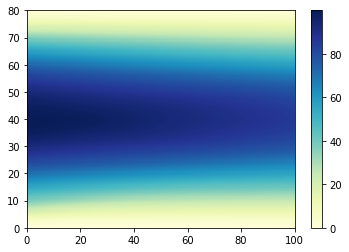

In [9]:
if __name__ == "__main__":
    # Domain bounds
    lb = np.array([0, 0.0])
    ub = np.array([80, 100.0])

    # initial condition
    ic_dataset = InitialConditionDataset1(n0=50)
    initial_condition = pf.InitialCondition(ic_dataset, name='Initial condition')

    # PDE
    pde_dataset = PDEDataset(20000, lb, ub)


    def heat1d(x, u):

        grads = ones(u.shape, device=u.device) # move to the same device as prediction
        grad_u = grad(u, x, create_graph=True, grad_outputs=grads)[0]

        # calculate first order derivatives
        u_x = grad_u[:, 0]
        u_t = grad_u[:, 1]
      
        # calculate second order derivatives
        grads = ones(u_x.shape, device=u.device)  # move to the same device as prediction
        grad_u_x = grad(u_x, x, create_graph=True, grad_outputs=grads)[0]
        u_xx = grad_u_x[:, 0]
        #print("u_xx", u_xx.shape)

        # reshape for correct behavior of the optimizer
        u_x = u_x.reshape(-1, 1)
        u_t = u_t.reshape(-1, 1)
        u_xx = u_xx.reshape(-1, 1)
        
        f = u_t - 1 * u_xx

        return f  # concatenate real part and imaginary part

    pde_loss = pf.PDELoss(pde_dataset, heat1d, name='1D Heat')
    # create model
    model = pf.models.MLP(input_size=2, output_size=1, hidden_size=100, num_hidden=4, lb=lb, ub=ub)
    
    # create PINN instance
    pinn = pf.PINN(model, 2, 1, pde_loss, initial_condition, [], use_gpu=True)
    
    # train pinn
    pinn.fit(5000, checkpoint_path='checkpoint.pt', restart=True, lbfgs_finetuning=False)
    pinn.load_model('best_model_pinn.pt')

    #Plotting
    max_t = 100
    max_x = 80

    t = np.linspace(0,max_t,500).flatten()[:, None]
    x = np.linspace(0,max_x,200).flatten()[:, None]
    X, T = np.meshgrid(x, t)

    X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    pred = pinn(Tensor(X_star).cuda())
    #pred = pinn(Tensor(X_star))

    pred_u = pred.detach().cpu().numpy()

    H_pred = pred_u.reshape(X.shape)
    plt.imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu',
                extent= [lb[1], ub[1], lb[0], ub[0]],
                origin='lower', aspect='auto')
    plt.colorbar()
    plt.show()



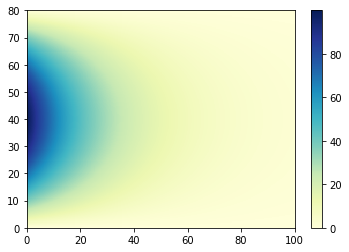

In [10]:
#Analytical Solution
#lb = np.array([0, 0.0])
#ub = np.array([80, 80])

t = np.linspace(0, 100, 500)
x = np.linspace(0, 80, 200)
X, T = np.meshgrid(x, t)
L=80
c=1
alpha = c*np.pi/L
U=100*(np.exp(-(alpha)*T))*np.sin(np.pi*X/L)

plt.imshow(U.T, interpolation='nearest', cmap='YlGnBu',
                extent= [lb[1], ub[1], lb[0], ub[0]],
                origin='lower', aspect='auto')

plt.axis()
plt.colorbar()
plt.show()
